<a href="https://colab.research.google.com/github/RusAl84/IntroML/blob/master/2_8_%D0%9F%D0%B5%D1%80%D0%B5%D0%BD%D0%BE%D1%81_%D0%BE%D0%B1%D1%83%D1%87%D0%B5%D0%BD%D0%B8%D1%8F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Перенос обучения

Нейронные сети большие и сложные. Чтобы хорошо обучить нейронную сеть нужно много времени, много релевантных данных. Скажем, сети для распознавания изображений обучаются на миллионах примеров изображений с тысячами разных классов, что требует недели и месяцы рассчетов, если, конечно, у вас нет компьютера с сотней-другой графических ускорителей.

У меня нет, а у вас? Что же, нам бросить заниматься нейронными сетями?

Оказывается, мы можем использовать чужие результаты, чтобы обучать, точней дообучать, нейронные сети для своих задач.

Такой подход назвали **перенос обучения** (transfer learning). Раньше, пока к делу не подключились крупные компании, даже были фирмы которые продавали обученные слои нейронной сети ("слои свежие, только обученные, подходи - покупай"), но, к счастью, теперь огромное количество уже хорошо обученных нейронных сетей доступны бесплатно всем желающим.  

Вспомним, как работает сеть для классификации изображений с прошлого занятия. Изображение проходит несколько раз через сверточные слои, активацию, другие слои (например, dropout), а затем, через полносвязный слой (обычно с softmax), который и рассчитывает уровни уверенности для классов.

Полносвязный слой это ведь обычная линейная регрессия. Значит все предыдущие слои так преобразовывали изображение, что оказалось достаточно линейной регрессии чтобы построить классификатор. Но, конечно, у нас это не получилось бы, если б мы пытались применить линейную регрессию сразу к изображению.

Можно сказать, что промежуточные слои это некоторые преобразователи, а последний слой - классификатор.

Но абсолютно теми же самыми рассуждениями можно придти к выводу, что классификатор это последние два слоя, а остальные - преобразователь. Или три...

Если мы имеем хорошо обученную нейронную сеть, то слои преобразователя хороши, они ведь позволяют потом построить классификатор.

А давайте возьмем "хороший" преобразователь от уже кем-то обученной сети (многие компании и ученые дают нам такие сети). А классификатор сделаем свой, для нашей задачи. Получится, что мы как бы отрезали последние слои у сети и заменили их на свои (рис.).

И уже эту сеть, с заранее обученным преобразователем, но еще не обученным классификатором, будем обучать. Тут можно как зафиксировать и не обучать слои от преобразователя (быстрота), так и продолжить их обучение вместе со слоями классификатора (точность).

![img](https://drive.google.com/uc?id=1bQubJ7HR9_7jT4RiVBCK4ttkuslO9jB8)


Вы решаете какие слои брать для преобразователя, какие для классификатора. Часто бывает так, что достаточно поменять лишь один последний слой.

На любом слое мы получаем некоторые карты признаков, и можем их использовать для классификатора. Мы **перенесли** обученные слои одной сети в другую.

Если нам надо обучить сеть распознавать изображения классов, которые никто не знает и не обучал, то нам нет необходимости делать это с нуля. Возьмем сеть, уже обученную распознавать большое число классов [ILSVRC](http://www.image-net.org/challenges/LSVRC/), и заменим в ней слои классификатора так, чтобы получались наши классы. И будем обучать уже такую составную сеть на новых примерах классов изображений.


## Пример

Давайте возьмем обученную сеть для классификации на  1000 классов [VGG16](https://arxiv.org/pdf/1409.1556.pdf) которая [победила в соревновании ImageNet в 2014](http://www.robots.ox.ac.uk/~vgg/research/very_deep/), и используем ее слои для классификации других классов изображений.

Мы загрузим VGG16, удалим последний ее слой (1000 нейронов с softmax) и заменим его на свой (97 нейронов и классов). Мы зафиксируем веса всех слоев, кроме последнего, т.е. не будем их обучать.

Сравним этот подход с попыткой обучить маленькую нейронную сеть с нуля.

В нашем примере мы используем набор данных из 6000 изображений с 97 классами.

In [ ]:
# %matplotlib inline
# подключаем библиотеки
import os
import random
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from tensorflow.keras.preprocessing import image # преодобработка изображений
from tensorflow.keras.applications.imagenet_utils import preprocess_input # преодобработка изображений для набора данных imagenet
from tensorflow.keras.models import Sequential # последовательное соединение слоев нейронной сети
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation # слои, которые будем использовать
from tensorflow.keras.layers import Conv2D, MaxPooling2D # слои, которые будем использовать
from tensorflow.keras.models import Model # объект нейронной сети в который собираются слои

### Загрузка набора данных

Мы используем набор данных [CalTech-101](http://www.vision.caltech.edu/Image_Datasets/Caltech101/), который отличается от ImageNet. Он содержит около 9000 размеченных изображений в 101 классе (в архиве файле есть еще 102ой класс с разными случайными картинками из интернета, но он нам не нужен). Мы исключим 5 классов с наибольшим числом изображений (включая 102ой), чтобы иметь классы с примерно одинаковым числом изображений в каждом (50-100), останется около 6000 изображений в 97 классах. Архив с данными хранится на нашем гугл-диске, чтобы скачать его оттуда используем  библиотеку `gdown`.

Если вы захотите обучать на своих классах, то должны сделать набор данных по аналогии с этим, где каждый класс хранится в поддиректориях, названия которых и определяют название классов. `root` - директория набора данных. Вспомогательная функция  `get_image(path)` загружает изображение и масштабирует его к размеру 224x224, чтобы подходило для VGG16.

In [ ]:
import gdown # модуль для загрузки с гугл-диска
url = 'https://drive.google.com/uc?id=1Madin3qXe3Xexox5qOhASGulFR2wvsFz' # адрес
output = '101_ObjectCategories.tar.gz' # название загружаемого файла
gdown.download(url, output, quiet=False) # загружаем


Downloading...
From: https://drive.google.com/uc?id=1Madin3qXe3Xexox5qOhASGulFR2wvsFz
To: /content/101_ObjectCategories.tar.gz
100%|██████████| 132M/132M [00:06<00:00, 19.0MB/s]


'101_ObjectCategories.tar.gz'

In [ ]:

!echo "Downloading 101_Object_Categories for image notebooks"
# распаковываем
!tar -xzf 101_ObjectCategories.tar.gz
# удаляем после распаковки
!rm 101_ObjectCategories.tar.gz
!ls


101_ObjectCategories  sample_data


In [ ]:
root = '101_ObjectCategories' # директория с файлами
exclude = ['BACKGROUND_Google', 'Motorbikes', 'airplanes', 'Faces_easy', 'Faces'] # классы, которые исключаем
train_split, val_split = 0.7, 0.15 # доли данных для обучения и проверки

# проходим по всем поддиректориям, они и есть наши классы
categories = [x[0] for x in os.walk(root) if x[0]][1:]
# но исключим некоторые из них
categories = [c for c in categories if c not in [os.path.join(root, e) for e in exclude]]
# посмотрим на классы. Специально оставили в названиях и общее название набора данных, чтобы не перепутать с другими
print(categories)

['101_ObjectCategories/crab', '101_ObjectCategories/buddha', '101_ObjectCategories/sunflower', '101_ObjectCategories/revolver', '101_ObjectCategories/inline_skate', '101_ObjectCategories/wheelchair', '101_ObjectCategories/garfield', '101_ObjectCategories/dolphin', '101_ObjectCategories/ewer', '101_ObjectCategories/dalmatian', '101_ObjectCategories/cup', '101_ObjectCategories/lotus', '101_ObjectCategories/windsor_chair', '101_ObjectCategories/stegosaurus', '101_ObjectCategories/beaver', '101_ObjectCategories/menorah', '101_ObjectCategories/rhino', '101_ObjectCategories/scorpion', '101_ObjectCategories/anchor', '101_ObjectCategories/gerenuk', '101_ObjectCategories/binocular', '101_ObjectCategories/mandolin', '101_ObjectCategories/joshua_tree', '101_ObjectCategories/cougar_body', '101_ObjectCategories/strawberry', '101_ObjectCategories/car_side', '101_ObjectCategories/elephant', '101_ObjectCategories/euphonium', '101_ObjectCategories/ibis', '101_ObjectCategories/watch', '101_ObjectCategor

In [ ]:
# функция для загрузки изображения
def get_image(path):
    img = image.load_img(path, target_size=(224, 224)) # загружаем изображение и масштабируем
    x = image.img_to_array(img) # конвертируем в массив
    x = np.expand_dims(x, axis=0) # добавляем измерение (batch) 1*224*224*3
    x = preprocess_input(x) # предобработка
    return img, x # возвращаем изображение PIL и массив для него

Загрузка всех изображений.

In [ ]:
data = [] # пустой массив для данных
for c, category in enumerate(categories): # для всех классов, они же поддиректории
    # берем названия всех файлов в ней, объединяем с названием (путем к) самой директории,
    # но только такие, в которых расширение '.jpg','.png','.jpeg'.
    images = [os.path.join(dp, f) for dp, dn, filenames
              in os.walk(category) for f in filenames
              if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
    # для всех изображений класса
    for img_path in images:
        img, x = get_image(img_path) # загружаем его
        data.append({'x':np.array(x[0]), 'y':c}) # добавляем в словарь 'x' - массив изображения и 'y' - номер класса.

# число классов
num_classes = len(categories)

In [ ]:
random.shuffle(data) # перемешаем случайно

In [ ]:
import sys


def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)





Обучающее, тестовое и проверочное множества (70%, 15%, 15%)



In [ ]:
N=5# часть данных для экономии
idx_val = int(train_split * len(data)/N) # индекс начала для проверочного множества
idx_test = int((train_split + val_split) * len(data)/N) # индекс начала для тестового множества
idx_end=int(int( 1 * len(data)/N))
# разделяем
train = data[:idx_val] #
val = data[idx_val:idx_test] #
test = data[idx_test:idx_end] #

In [ ]:
# разделяем данные и метки в отдельные переменные
x_train, y_train = np.array([t["x"] for t in train]), np.array([t["y"] for t in train])
x_val, y_val = np.array([t["x"] for t in val]), np.array([t["y"] for t in val])
x_test, y_test = np.array([t["x"] for t in test]), np.array([t["y"] for t in test])
#print(y_test)

In [ ]:
# Память
for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
                         key= lambda x: -x[1])[:20]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

                       x_train: 499.0 MiB
                         x_val: 106.8 MiB
                        x_test: 106.8 MiB
                          data: 53.3 KiB
                       y_train:  6.9 KiB
                         train:  6.9 KiB
                           _i1:  1.6 KiB
                         y_val:  1.6 KiB
                        y_test:  1.6 KiB
                           _i6:  1.5 KiB
                           val:  1.5 KiB
                          test:  1.5 KiB
                           _i4:  1.3 KiB
                    Sequential:  1.0 KiB
                         Dense:  1.0 KiB
                       Dropout:  1.0 KiB
                       Flatten:  1.0 KiB
                    Activation:  1.0 KiB
                        Conv2D:  1.0 KiB
                  MaxPooling2D:  1.0 KiB


Предобработка, перевод в float32 и нормализация к 0...1. Кодирование классов.

In [ ]:
# нормализация
x_train = x_train.astype('float32') / 255.
x_val = x_val.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.


In [ ]:
# НЕНАДО для sparse cross entropy
# конвертируем номера классов в one-hot вектора
#y_train = tf.keras.utils.to_categorical(y_train, num_classes)
#y_val =   tf.keras.utils.to_categorical(y_val, num_classes)
#y_test =  tf.keras.utils.to_categorical(y_test, num_classes)
#print(y_test.shape)

In [ ]:
# ЕСЛИ sparse cross entropy
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

Что у нас получилось:

In [ ]:
# summary
print("finished loading %d images from %d categories"%(len(data), num_classes))
print("train / validation / test split: %d, %d, %d"%(len(x_train), len(x_val), len(x_test)))
print("training data shape: ", x_train.shape)
print("training labels shape: ", y_train.shape)


finished loading 6209 images from 97 categories
train / validation / test split: 869, 186, 186
training data shape:  (869, 224, 224, 3)
training labels shape:  (869,)


Если все правильно, то должен получиться набор изображений, разделенный на `train`, `val`, и `test`.

Размер данных входа (`n`, 224, 224, 3) где `n` число примеров.

Указания учителя имеют размер (`n`, `c`) где `c` - число классов (97 в нашем примере `101_ObjectCategories`), если используем кросс-энтропию, и (`n`,), если используем разреженную кросс-энтропию, в последнем случае классы кодируются своим номером.


Посмотрим на некоторые изображения.

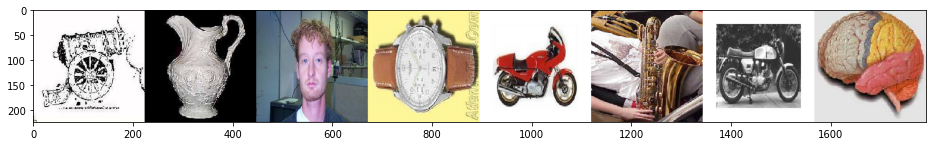

In [ ]:
# названия всех изображений
images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(root) for f in filenames if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
# выбираем случайно 8 штук
idx = [int(len(images) * random.random()) for i in range(8)]
# загружаем эти изображения
imgs = [image.load_img(images[i], target_size=(224, 224)) for i in idx]
# объединяем в одну строку
concat_image = np.concatenate([np.asarray(img) for img in imgs], axis=1)
# рисуем
plt.figure(figsize=(16,4))
plt.imshow(concat_image)

# Обучение нейронной сети с нуля

Эта нейронная сеть будет состоять из 4 сверточных слоев и max-pooling, со слоем [dropout](https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf) после каждых двух слоев свертки\пулинга. Затем подключаем полносвязный слой с 128 нейронами, еще слой dropout, и, наконец, полносвязный слой с softmax для классификации (а сколько в нем нейронов?).

Функцию ошибки возьмем кросс-энтропию, метод обучения Adam.

Вы можете поменять параметры.

In [ ]:
# создаем нейронную сеть
channels=16
model = Sequential() # последовательное подключение слоев
print("Input dimensions: ",x_train.shape[1:]) # размер входа

model.add(Conv2D(channels, (3, 3), input_shape=x_train.shape[1:])) #  свертка
model.add(Activation('relu')) # активация
model.add(MaxPooling2D(pool_size=(2, 2))) # пулинг

model.add(Conv2D(channels, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25)) # dropout

model.add(Conv2D(channels, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(channels, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Flatten()) # вытягиваем результаты сверток в вектор
model.add(Dense(128))# полносвязный слой
model.add(Activation('relu'))

model.add(Dropout(0.5))

model.add(Dense(num_classes)) # полносвязный слой классификации
model.add(Activation('softmax')) # активация softmax

model.summary() # напечатаем информацию о сети

Input dimensions:  (224, 224, 3)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 activation (Activation)     (None, 222, 222, 16)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 16)      2320      
                                                                 
 activation_1 (Activation)   (None, 109, 109, 16)      0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 16)       0         
 2D)                   

Мы получили сеть в которой ~0.3 млн. весов и смещений, большинство из них в первом полносвязном слое.

Будем обучать нашу модель 20  эпох (поменяйте) с пакетом размера 64. Будем записывать историю.

In [ ]:
# компилируем модель и указываем опции обучения
model.compile(loss='SparseCategoricalCrossentropy', #  функция ошибки
              optimizer='adam', # метод обучения
              metrics=['accuracy']) #  измеряемые метрики



In [ ]:
# обучаем модель
history = model.fit(x_train, # примеры входа
                    y_train, # указания учителя
                    batch_size=32, # размер пакета
                    epochs=20, # количество эпох
                    validation_data=(x_val, y_val)) #  данные для проверки


Epoch 1/20
28/28 [==============================] - 13s 50ms/step - loss: 4.5762 - accuracy: 0.0173 - val_loss: 4.5603 - val_accuracy: 0.0376
Epoch 2/20
28/28 [==============================] - 1s 30ms/step - loss: 4.5260 - accuracy: 0.0380 - val_loss: 4.5256 - val_accuracy: 0.0376
Epoch 3/20
28/28 [==============================] - 1s 30ms/step - loss: 4.4093 - accuracy: 0.0541 - val_loss: 4.4705 - val_accuracy: 0.0484
Epoch 4/20
28/28 [==============================] - 1s 30ms/step - loss: 4.2723 - accuracy: 0.0783 - val_loss: 4.3877 - val_accuracy: 0.0806
Epoch 5/20
28/28 [==============================] - 1s 37ms/step - loss: 4.1157 - accuracy: 0.1013 - val_loss: 4.2935 - val_accuracy: 0.0860
Epoch 6/20
28/28 [==============================] - 1s 42ms/step - loss: 3.8362 - accuracy: 0.1530 - val_loss: 4.2071 - val_accuracy: 0.1183
Epoch 7/20
28/28 [==============================] - 1s 42ms/step - loss: 3.4674 - accuracy: 0.1979 - val_loss: 4.1152 - val_accuracy: 0.1452
Epoch 8/20
2

Построим графики для функции ошибки и метрики аккуратности на проверочных данных.

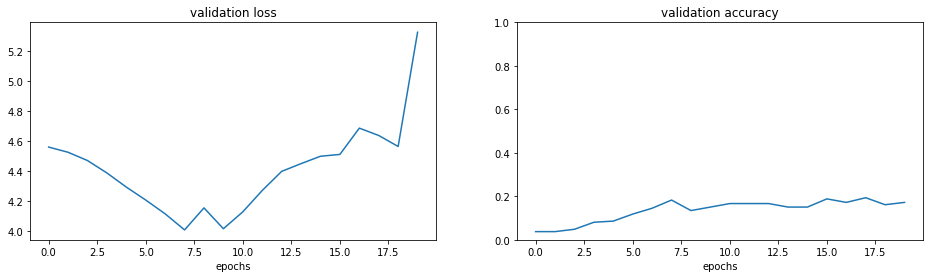

In [ ]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"]) # функция ошибки
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"]) # метрика аккуратности
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

Получили что-то около 20% аккуратности. Вряд ли за малое время обучения она возрастет существенно, попытайтесь.

Проверим на тестовых данных.

In [ ]:
# Память
for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
                         key= lambda x: -x[1])[:20]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

                       x_train: 499.0 MiB
                         x_val: 106.8 MiB
                        x_test: 106.8 MiB
                  concat_image:  1.1 MiB
                        images: 76.0 KiB
                          data: 53.3 KiB
                       y_train:  6.9 KiB
                         train:  6.9 KiB
                          _i17:  2.1 KiB
                           _i1:  1.6 KiB
                         y_val:  1.6 KiB
                        y_test:  1.6 KiB
                           _i6:  1.5 KiB
                           val:  1.5 KiB
                          test:  1.5 KiB
                           _i4:  1.3 KiB
                          _i16:  1.1 KiB
                         Model:  1.0 KiB
                    categories:  920.0 B
                    Sequential:  896.0 B


In [ ]:
# del history

In [ ]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=0) # проверяем на тестовых данных
print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 5.761359691619873
Test accuracy: 0.20430107414722443


Итак, аккуратность около 50%. Не так плохо, но и не так хорошо. Для 97 классов, если бы мы случайно угадывали бы класс, получили бы что-то около 1% аккуратности.

# Используем предобученную сеть

Теперь сделаем тоже самое, но будем использовать уже обученную сеть, а заменим только слои для классификации.

In [ ]:
# скачиваем обученную сеть
from tensorflow.keras import applications
vgg = applications.VGG16(weights='imagenet', include_top=True)
vgg.summary() # ее описание

553476096/553467096 [==============================] - 8s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

Эта сеть, VGG16, _гораздо_ больше нашей. Содержит 13 сверточных слоев, два полносвязных и более 138 миллионов обучаемых параметров, что почти в 250 раз больше чем было у нас.

VGG16 обучалась на ImageNet и показала [8.8% top-5 ошибку](https://github.com/jcjohnson/cnn-benchmarks), это значит что 91.2% тестовых примеров были классифицированы правильно и верные классы входили в top 5 самых уверенных. top-1 аккуратность около 73%. И при этом в ней не 97, а 1000 классов (случайное угадывание дало бы 0.1% аккуратности).

Чтобы использовать такую сеть мы "отрежем" последний слой с 1000 нейронами (которые отвечают за 1000 классов ImageNet) и заменим его на слой с 97 нейронами для нашего набора данных.

Технически мы не будем ничего отрезать, а сделаем копию слоев VGG до предпоследнего. Используем класс `Model` чтобы создать сеть, объединяя вход VGG, и слои VGG до предпоследнего с новым слоем, названного `new_classification_layer`. Мы возьмем выход предпоследнего слоя VGG и подадим его на новый слой. Не беспокойтесь что при копировании мы тратим память, Keras просто ссылается на нужные места и фактически ничего не копируется.

In [ ]:
# ссылка на вход VGG
inp = vgg.input

# новый полносвязный слой классификации с softmax и num_classes нейронов
new_classification_layer = Dense(num_classes, activation='softmax')

# подключаем новый слой к выходу предпоследнего слоя VGG (индекс -2), и делаем ссылку на него
out = new_classification_layer(vgg.layers[-2].output)

# создаем сеть от входа до нового выхода.
model_new = Model(inp, out)


Мы будем обучать эту сеть `model_new` на новых изображениях и классах, но мы заморозим (зафиксируем) веса и смещения у всех слоев, кроме нового последнего и будем обучать только последний слой. Устанавливаем флаг `trainable` в false. Если время и ресурсы позволяют, можете обучать и всю сеть целиком.

В качестве упражнения разрешите обучать также веса предпоследнего слоя.

In [ ]:
# запрещаем обучение всех весов\смещений для слоев кроме последнего
for l, layer in enumerate(model_new.layers[:-1]):
    layer.trainable = False

# на всякий случай последнему слою разрешаем обучаться
for l, layer in enumerate(model_new.layers[-1:]):
    layer.trainable = True

# компилируем модель и указываем опции обучения
model_new.compile(loss='SparseCategoricalCrossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_new.summary() # печатаем информацию о модели

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

Получили сеть похожую на исходную VGG, кроме последнего слоя, имеем 134 миллиона параметров, но обучаемых среди них только 397 тысяч, почти столько же, как в нашей собственной сети.

Обучаем.

In [ ]:
# обучаем
history2 = model_new.fit(x_train, y_train,
                         batch_size=16,
                         epochs=20,
                         validation_data=(x_val, y_val))


Epoch 1/20
55/55 [==============================] - 10s 137ms/step - loss: 5.5654 - accuracy: 0.0702 - val_loss: 4.4898 - val_accuracy: 0.1290
Epoch 2/20
55/55 [==============================] - 5s 95ms/step - loss: 3.3838 - accuracy: 0.2946 - val_loss: 3.3548 - val_accuracy: 0.2957
Epoch 3/20
55/55 [==============================] - 5s 95ms/step - loss: 2.5404 - accuracy: 0.4350 - val_loss: 3.3086 - val_accuracy: 0.2957
Epoch 4/20
55/55 [==============================] - 5s 96ms/step - loss: 2.0927 - accuracy: 0.5086 - val_loss: 2.7236 - val_accuracy: 0.3763
Epoch 5/20
55/55 [==============================] - 5s 96ms/step - loss: 1.7391 - accuracy: 0.5811 - val_loss: 2.7041 - val_accuracy: 0.3763
Epoch 6/20
55/55 [==============================] - 5s 96ms/step - loss: 1.4975 - accuracy: 0.6548 - val_loss: 2.3702 - val_accuracy: 0.4194
Epoch 7/20
55/55 [==============================] - 5s 96ms/step - loss: 1.2468 - accuracy: 0.7123 - val_loss: 2.7425 - val_accuracy: 0.3333
Epoch 8/20


Аккуратность около 50%, что  на 30% больше, чем ранее. Проверьте, а быстрей ли эта сеть или нет?
Одна эпоха старой сети длилась примерно 1 сек., в новой сети около 5 сек. Но новая сеть имеет в 250 раз больше параметров, большая часть из которых уже обучена заранее, нам не надо тратить свое время на них. Обучается в новой сети примерно такое же количество параметров, но качество гораздо лучше.  

Построим графики (оранжевая - новая сеть).

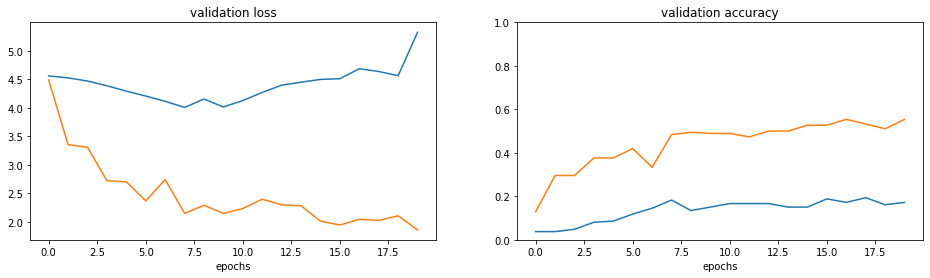

In [ ]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"]) # функция ошибки предыдущей сети
ax.plot(history2.history["val_loss"]) # функция ошибки этой сети
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"]) # аккуратность предыдущей сети
ax2.plot(history2.history["val_accuracy"]) # аккуратность этой сети
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

Проверим на тестовых данных.

In [ ]:
loss, accuracy = model_new.evaluate(x_test, y_test, verbose=0)

print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 1.8203376531600952
Test accuracy: 0.602150559425354


Для работы с новыми изображениями рассчитайте уровни уверенности классов, выберите максимальный.

101_ObjectCategories/helicopter 0.73802394


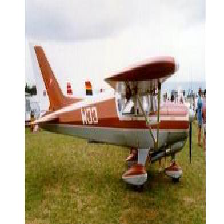

In [ ]:
img, x = get_image('101_ObjectCategories/airplanes/image_0009.jpg')
probabilities = model_new.predict([x])
id=np.argmax(probabilities)
print(categories[id],probabilities[0,id])
img

Вопрос, а почему в примере выше вы никогда не получите правильный класс airplanes?

Почему это работает?
Изображения схожи между собой. Взаимосвязи пикселей, а именно они устанавливаются при обучении, похожи, неважно различаете вы котика от собачек или слоников от бегемотиков. Или как говорят - схожие домены.

_лапка-лапка, хвостик-хвостик, глазик-глазик_
![img](https://media.gettyimages.com/vectors/animals-elephant-cat-zebra-giraffe-rhino-lion-gazelle-vector-id165079601?s=2048x2048)

Наверное, если природа изображений существенно отличается, то перенос обучения не поможет. Например, захотите различать шумы аналогового телевизора и фотографию гравия. Вряд ли здесь поможет сеть, обученная на распознавание бытовых картинок.

![img](https://media.istockphoto.com/photos/static-background-picture-id124532805)
![img](https://media.istockphoto.com/photos/wash-gravel-floors-on-the-outside-of-the-building-picture-id1184617226)

# Ссылки
Использованы и адаптированы материалы:

https://colab.research.google.com/github/kylemath/ml4a-guides/blob/master/notebooks/transfer-learning.ipynb

